# Variational Autoencoder (VAE)

Real Image --> Encoder ---> Latent Space ---> Decoder ---> Generated Image 

In [13]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torch.distributions.kl import kl_divergence

from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms


from torchvision.utils import make_grid
from tqdm import tqdm
import time


'''Mapping the input image to a latent space representation'''
#Classifier 
class Encoder(nn.Module):

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1) # reshapes disc_pred to 1-D tensor. 
        '''Outputs mean and standard deviations of the gaussian distribution'''
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp() # reshapes seperating the mean and standard deviation

#DCGAN generator Architecture
class Decoder(nn.Module):

    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
       
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

## VAE

In [4]:

class VAE(nn.Module):
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev) # normal distribution 
        # samples a latent vector from q_dist using the reparameterization trick (rsamples() method)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        
        decoding = self.decode(z_sample) # creates a image 
        return decoding, q_dist # returns the reconstructed image and the q_dist object

###  ELBO  - Evidence Lower Bound

In [5]:
'''Loss functions'''
# BCE loss, pixel wise difference between the inputs and the reconstructed images.
reconstruction_loss = nn.BCELoss(reduction='sum') # reduction = 'sum' means that loss will be summed across all the pixels in the batch

### KL Divergence

In [7]:

'''Computes the Kullback-Leibler(KL) Divergence between the learned distribution and the standard normal distribution'''
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev)) # mean is 0 and std_dev is 1
    ).sum(-1)

### Training a VAE

In [11]:

transform=transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = datasets.MNIST('.', train=True, transform=transform)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

Epoch 0


100%|██████████| 59/59 [00:10<00:00,  5.54it/s]


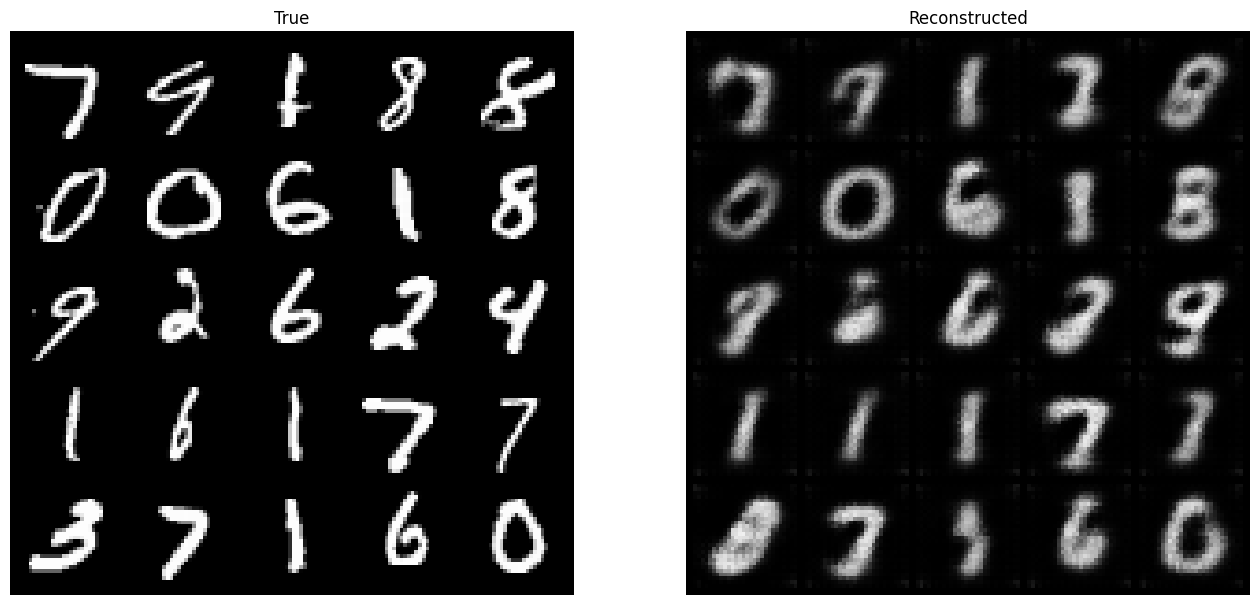

Epoch 1


100%|██████████| 59/59 [00:09<00:00,  6.14it/s]


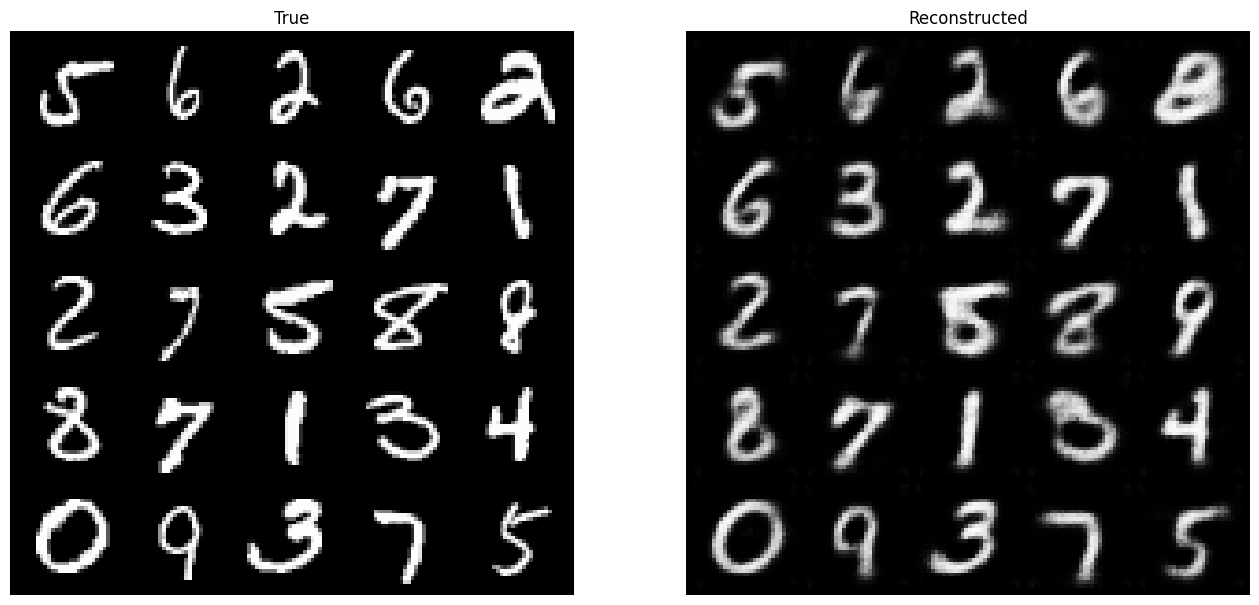

Epoch 2


100%|██████████| 59/59 [00:09<00:00,  6.03it/s]


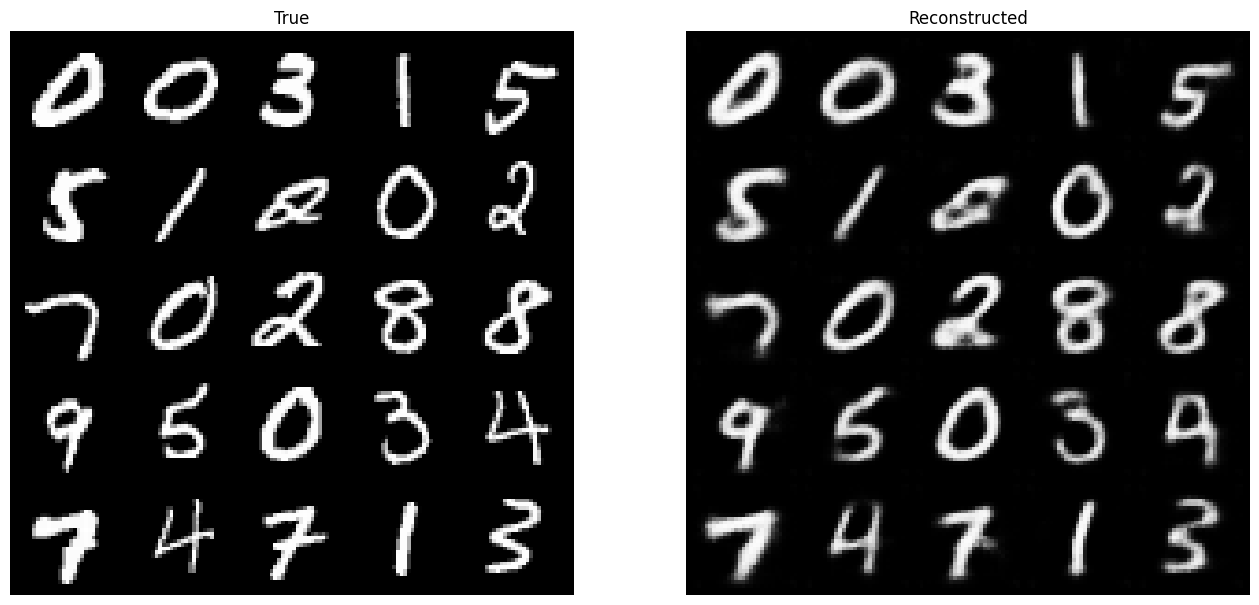

Epoch 3


100%|██████████| 59/59 [00:09<00:00,  6.10it/s]


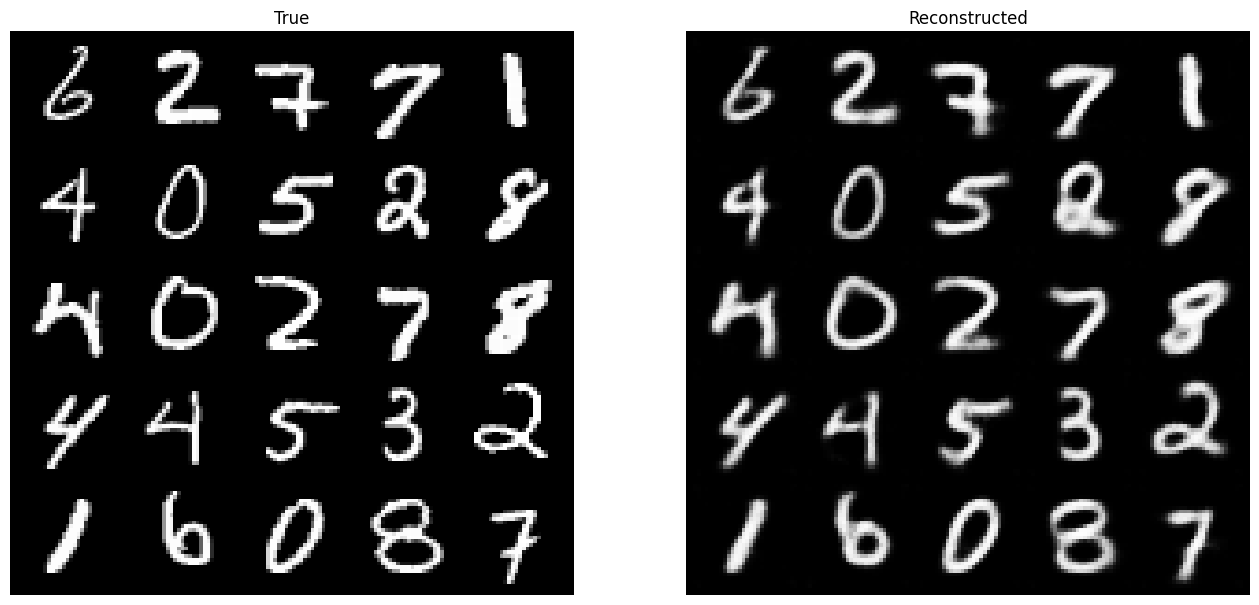

Epoch 4


100%|██████████| 59/59 [00:09<00:00,  5.99it/s]


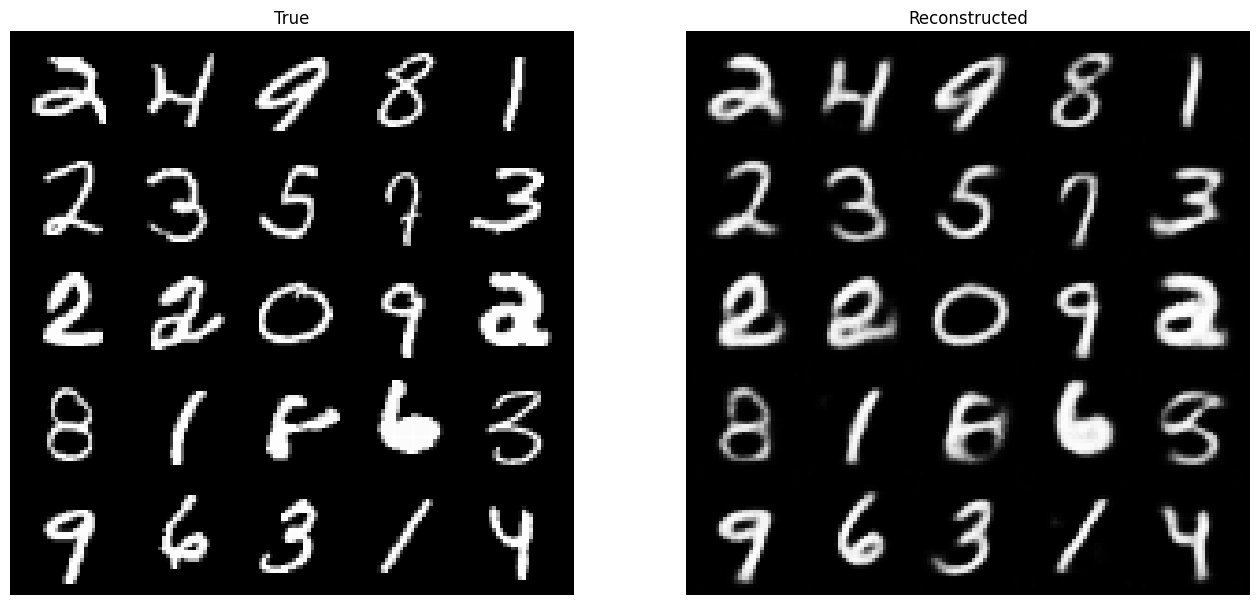

Epoch 5


100%|██████████| 59/59 [00:10<00:00,  5.78it/s]


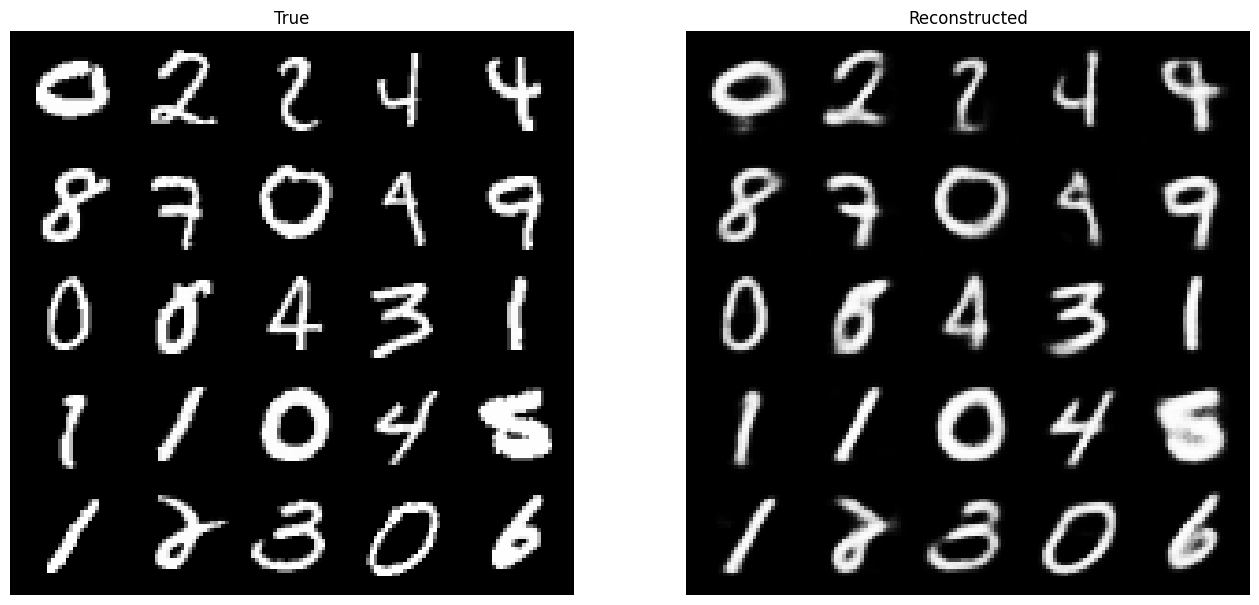

Epoch 6


100%|██████████| 59/59 [00:10<00:00,  5.77it/s]


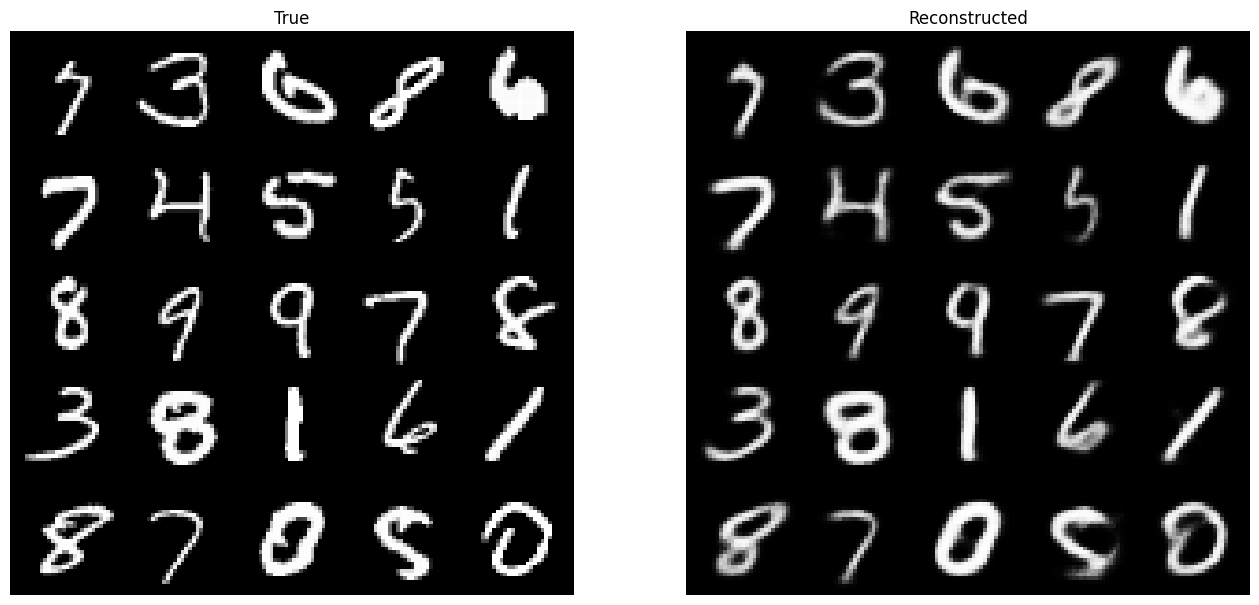

Epoch 7


100%|██████████| 59/59 [00:10<00:00,  5.78it/s]


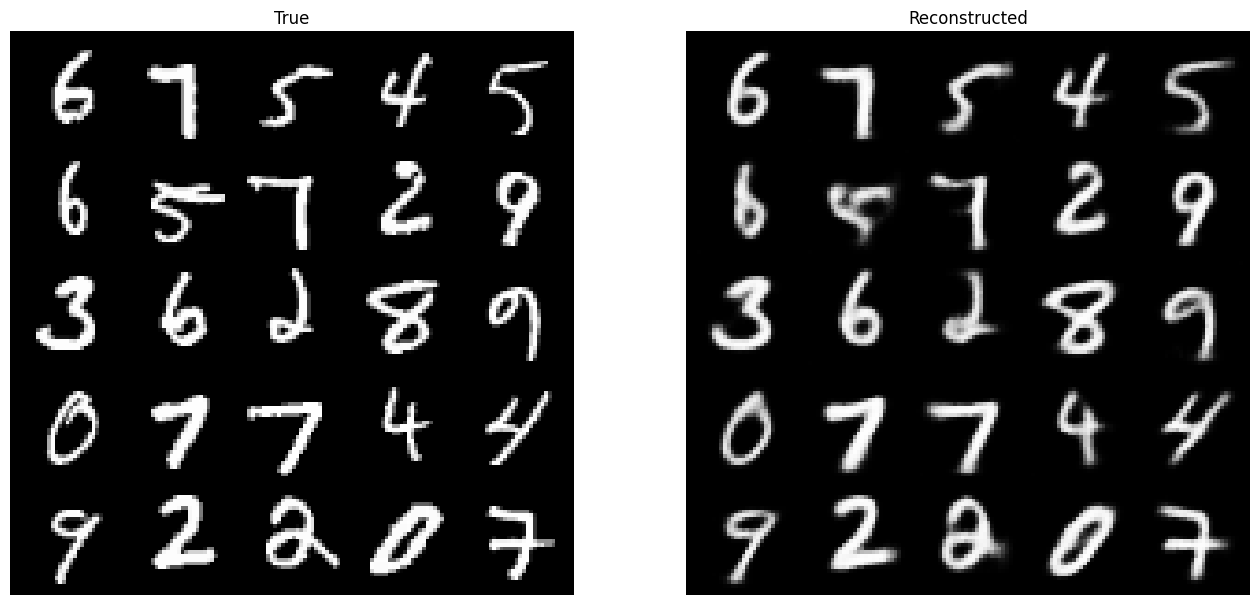

Epoch 8


100%|██████████| 59/59 [00:10<00:00,  5.75it/s]


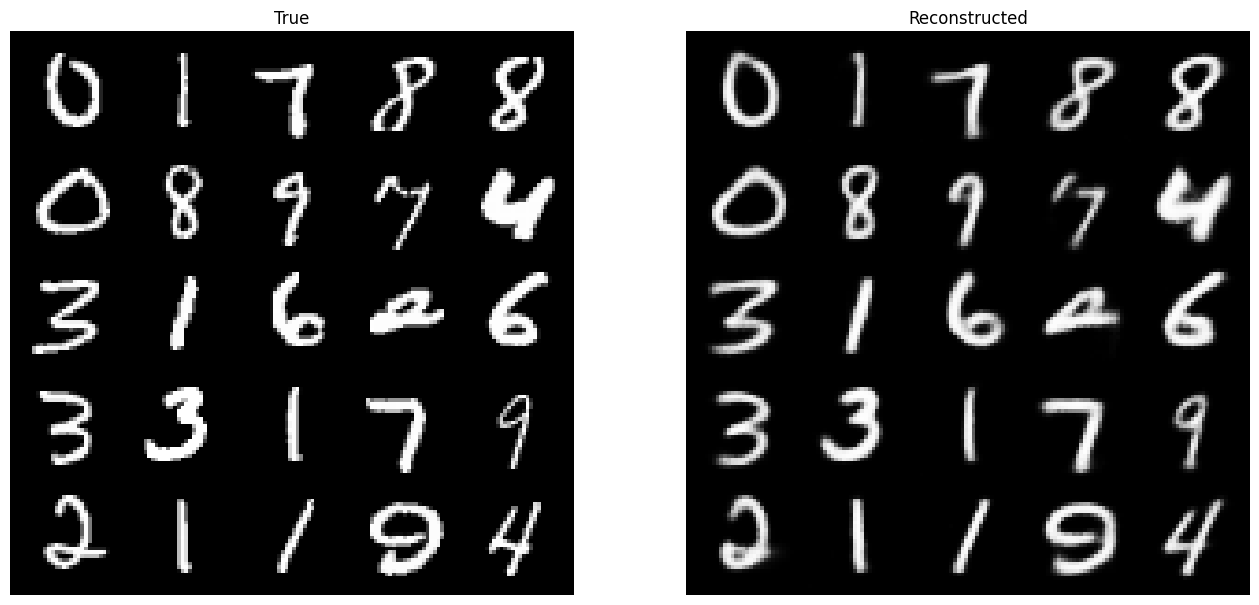

Epoch 9


100%|██████████| 59/59 [00:10<00:00,  5.73it/s]


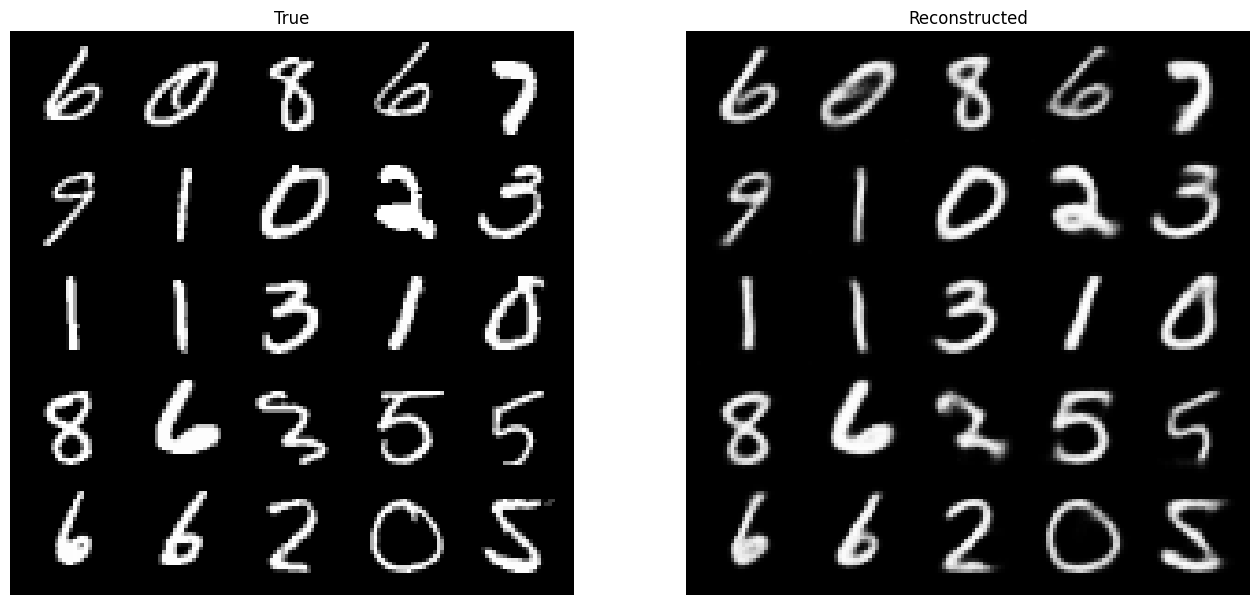

In [12]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())


device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)

'''Training '''
for epoch in range(10):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    for images, _ in tqdm(train_dataloader):
        images = images.to(device)
        vae_opt.zero_grad() # Clear out the gradients
        recon_images, encoding = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        vae_opt.step()
        
        
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()

$\beta$-VAEs - we can weight the KL-divergence term differently 

VQ-VAE2 - Autoregressice hybrid generative model

VAE-GAN - Hybrid generative model that uses adversarial loss on a VAE